In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt
import numpy as np
from numpy.random import seed
seed(1)
import random as rn
rn.seed(1)
import random
import tensorflow as tf
tf.compat.v1.random.set_random_seed(1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#define hyperparameters
 # number of output which is one in our case
n_out=1
#duration of a season
seq_len=240

#number of hidden units in each LSTM layer
hidden_units=128
dropout_size=0.2
#learning rate
lr=0.001
#learning rate decay
decay=1e-5
Batch_size=64
#maximum number of epochs to train the model
Epoch=200
#save the trained model with the name
NAME = "BLSTM_Crop_Yield_Prediction_20.h5"

# Define file paths
file1 = '/content/maize_United_States.csv'

# Load datasets
df = pd.read_csv(file1)


# Check for duplicates and remove them if needed
df = df.drop_duplicates()


In [ ]:


df.drop(['crop', 'State', 'Country'], axis=1, inplace=True)
#remove the columns with missing data
df.dropna(inplace=True)
#remove the variable with VIF greater than a threshold from the data set
#df.drop(['Tmin','Tmax', 'Humidity_min',  'Humidity_max','Solar R_Avg'],axis=1 ,inplace=True)

In [ ]:

def data_preprocessing(df):
    values = df.values
    scaler = MinMaxScaler()
    values_normal = scaler.fit_transform(values)
    df = pd.DataFrame(values_normal, columns=df.columns, index=df.index)

    return df, scaler

In [ ]:
# Split the dataset into input and output for supervised learning
def data_split(df, train=True):
    sequential_data = []
    season = []
    for index, i in enumerate(df.values):
        season.append([n for n in i[:-1]])  # All columns except the last one (yield)
        if len(season) == seq_len:
            sequential_data.append([np.array(season), i[-1]])  # Last column is the target (yield)
            season.clear()

    if train:
        random.shuffle(sequential_data)

    X = []
    Y = []
    for seq, target in sequential_data:
        X.append(seq)
        Y.append(target)
    return np.array(X), np.array(Y)


In [ ]:
# Split the dataset into input and output for supervised learning

def data_split(df, train=True):
    sequential_data = []
    season = []
    for index, i in enumerate(df.values):
        season.append(i[:-1].tolist())  # All columns except the last one (yield)
        if len(season) == seq_len:
            sequential_data.append([np.array(season), i[-1]])  # Last column is the target (yield)
            season.clear()

    if train:
        random.shuffle(sequential_data)

    X = []
    Y = []
    for seq, target in sequential_data:
        X.append(seq)
        Y.append(target)
    return np.array(X), np.array(Y)

# First split the data for supervised learning using the data_split function
X, Y = data_split(df)
indices = np.arange(len(X))

# Split into training and test set
X_train, x_test, y_train, y_test, ind1, ind2 = train_test_split(X, Y, indices, test_size=0.2, random_state=42)

In [ ]:
X.shape

(41141, 240, 12)

In [ ]:
Y

array([11.35900021,  6.53399992,  8.17099953, ...,  5.02699995,
        9.55900002, 10.06299973])

In [ ]:
# Concatenate the X_train and y_train for preprocessing
X_train_reshape = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
Y_train_reshape = np.concatenate((y_train, np.zeros((X_train.shape[0] * X_train.shape[1]) - len(y_train))), axis=0)
y_train_reshape = Y_train_reshape.reshape(-1, 1)
data = np.concatenate((X_train_reshape, y_train_reshape), axis=1)
data = pd.DataFrame(data)

# Preprocessing the training set
data, scaler = data_preprocessing(data)

# Split the preprocessed data into the training variable and label
X_train_minmax = data.values[:, :-1]
y_train = data.values[:len(y_train), -1]
X_train = np.reshape(X_train_minmax, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))


In [ ]:
# Save the scaler for later use
import joblib
joblib.dump(scaler, 'minmax_scaler.save')

['minmax_scaler.save']

In [ ]:
X_train

array([[[0.73684211, 0.14705882, 0.93333333, ..., 0.        ,
         0.64480432, 1.        ],
        [0.73684211, 0.14705882, 0.93333333, ..., 0.        ,
         0.64480432, 1.        ],
        [0.73684211, 0.14705882, 0.93333333, ..., 0.        ,
         0.64480432, 1.        ],
        ...,
        [0.73684211, 0.14705882, 0.93333333, ..., 0.        ,
         0.64480432, 1.        ],
        [0.73684211, 0.14705882, 0.93333333, ..., 0.        ,
         0.64480432, 1.        ],
        [0.73684211, 0.14705882, 0.93333333, ..., 0.        ,
         0.64480432, 1.        ]],

       [[0.73684211, 0.11764706, 0.8       , ..., 0.        ,
         0.64480432, 0.71428571],
        [0.73684211, 0.11764706, 0.8       , ..., 0.        ,
         0.64480432, 0.71428571],
        [0.73684211, 0.11764706, 0.8       , ..., 0.        ,
         0.64480432, 0.71428571],
        ...,
        [0.73684211, 0.11764706, 0.8       , ..., 0.        ,
         0.64480432, 0.71428571],
        [0.7

In [ ]:
X_train_reshape.shape

(7898880, 12)

In [ ]:
x_test.shape

(8229, 240, 12)

In [ ]:
#The r2_square metric for evaluating the model
def r_square(y_true, y_pred):
    y_true= tf.convert_to_tensor(y_true, np.float32)
    SS_res = tf.keras.backend.sum(tf.keras.backend.square( y_true-y_pred ))
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square( y_true - tf.keras.backend.mean(y_true) ) )
    return np.array(( 1 - SS_res/(SS_tot + tf.keras.backend.epsilon()) ))

In [ ]:
X_train.shape[1]

240

In [ ]:
X_train.shape[2]

12

In [ ]:
# Define the BLSTM model for crop yield prediction
from tensorflow.keras.optimizers import Nadam


def BLstm_model():
    input1 = tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
    blstm_1 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=True, name='blstm1')
    )(input1)
    drop1 = tf.keras.layers.Dropout(dropout_size)(blstm_1)

    blstm_2 = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, activation='tanh', return_sequences=False, name='blstm2')
    )(drop1)
    drop2 = tf.keras.layers.Dropout(dropout_size)(blstm_2)

    dense_1 = tf.keras.layers.Dense(hidden_units * 2, activation='relu')(drop2)  # Increased hidden units
    dense_2 = tf.keras.layers.Dense(hidden_units, activation='relu')(dense_1)  # Added one more dense layer
    output = tf.keras.layers.Dense(n_out)(dense_2)


    model = tf.keras.Model(inputs=input1, outputs=output)

    optimizer = Nadam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [ ]:
#creat the mode1 using Lstm_model function
model=BLstm_model()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 12)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 240, 256)            │         144,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 240, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 637,441 (2.43 MB)

 Trainable params: 637,441 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the early stopping callback
Early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=50,  # Adjusted patience for yield prediction
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# Define the checkpoint callback to save the model with the best validation loss
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="BLSTM_7_crop_yield_prediction_20.h5",  # Updated filename
    monitor="val_loss",
    mode='min',
    verbose=1,
    save_best_only=True
)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

history = model.fit(
    X_train,
    y_train,
    batch_size=Batch_size,
    epochs=200,
    validation_split=0.2,
    callbacks=[checkpoint, Early, reduce_lr]
)

Epoch 1/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0208 - mae: 0.1099
Epoch 1: val_loss improved from inf to 0.01573, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step - loss: 0.0207 - mae: 0.1099 - val_loss: 0.0157 - val_mae: 0.0976 - learning_rate: 0.0010
Epoch 2/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0149 - mae: 0.0943
Epoch 2: val_loss improved from 0.01573 to 0.01412, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - loss: 0.0149 - mae: 0.0943 - val_loss: 0.0141 - val_mae: 0.0913 - learning_rate: 0.0010
Epoch 3/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0138 - mae: 0.0903
Epoch 3: val_loss improved from 0.01412 to 0.01277, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.0138 - mae: 0.0903 - val_loss: 0.0128 - val_mae: 0.0866 - learning_rate: 0.0010
Epoch 4/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0131 - mae: 0.0875
Epoch 4: val_loss improved from 0.01277 to 0.01235, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0131 - mae: 0.0875 - val_loss: 0.0124 - val_mae: 0.0852 - learning_rate: 0.0010
Epoch 5/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0126 - mae: 0.0858
Epoch 5: val_loss did not improve from 0.01235
412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.0126 - mae: 0.0858 - val_loss: 0.0131 - val_mae: 0.0885 - learning_rate: 0.0010
Epoch 6/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0125 - mae: 0.0855
Epoch 6: val_loss improved from 0.01235 to 0.01225, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - loss: 0.0125 - mae: 0.0855 - val_loss: 0.0122 - val_mae: 0.0851 - learning_rate: 0.0010
Epoch 7/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0120 - mae: 0.0835
Epoch 7: val_loss did not improve from 0.01225
412/412 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 0.0120 - mae: 0.0835 - val_loss: 0.0126 - val_mae: 0.0864 - learning_rate: 0.0010
Epoch 8/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0118 - mae: 0.0825
Epoch 8: val_loss improved from 0.01225 to 0.01169, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - loss: 0.0118 - mae: 0.0825 - val_loss: 0.0117 - val_mae: 0.0827 - learning_rate: 0.0010
Epoch 9/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0113 - mae: 0.0804
Epoch 9: val_loss improved from 0.01169 to 0.01099, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 0.0113 - mae: 0.0804 - val_loss: 0.0110 - val_mae: 0.0801 - learning_rate: 0.0010
Epoch 10/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0110 - mae: 0.0798
Epoch 10: val_loss did not improve from 0.01099
412/412 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - loss: 0.0110 - mae: 0.0798 - val_loss: 0.0111 - val_mae: 0.0800 - learning_rate: 0.0010
Epoch 11/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0121 - mae: 0.0834
Epoch 11: val_loss did not improve from 0.01099
412/412 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 0.0121 - mae: 0.0834 - val_loss: 0.0117 - val_mae: 0.0834 - learning_rate: 0.0010
Epoch 12/20
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0114 - mae: 0.0810
Epoch 12: val_loss improved from 0.01099 to 0.01013, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0114 - mae: 0.0810 - val_loss: 0.0101 - val_mae: 0.0760 - learning_rate: 0.0010
Epoch 13/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0105 - mae: 0.0776
Epoch 13: val_loss did not improve from 0.01013
412/412 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0105 - mae: 0.0776 - val_loss: 0.0111 - val_mae: 0.0797 - learning_rate: 0.0010
Epoch 14/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0101 - mae: 0.0762
Epoch 14: val_loss improved from 0.01013 to 0.00941, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.0101 - mae: 0.0762 - val_loss: 0.0094 - val_mae: 0.0734 - learning_rate: 0.0010
Epoch 15/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0098 - mae: 0.0753
Epoch 15: val_loss improved from 0.00941 to 0.00933, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 0.0098 - mae: 0.0753 - val_loss: 0.0093 - val_mae: 0.0729 - learning_rate: 0.0010
Epoch 16/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0095 - mae: 0.0738
Epoch 16: val_loss improved from 0.00933 to 0.00917, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0095 - mae: 0.0738 - val_loss: 0.0092 - val_mae: 0.0724 - learning_rate: 0.0010
Epoch 17/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0093 - mae: 0.0728
Epoch 17: val_loss improved from 0.00917 to 0.00880, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0093 - mae: 0.0728 - val_loss: 0.0088 - val_mae: 0.0705 - learning_rate: 0.0010
Epoch 18/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0089 - mae: 0.0712
Epoch 18: val_loss did not improve from 0.00880
412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - loss: 0.0089 - mae: 0.0712 - val_loss: 0.0093 - val_mae: 0.0725 - learning_rate: 0.0010
Epoch 19/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0086 - mae: 0.0700
Epoch 19: val_loss improved from 0.00880 to 0.00863, saving model to BLSTM_7_crop_yield_prediction_20.h5


412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0086 - mae: 0.0700 - val_loss: 0.0086 - val_mae: 0.0702 - learning_rate: 0.0010
Epoch 20/20
411/412 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0088 - mae: 0.0708
Epoch 20: val_loss did not improve from 0.00863
412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0088 - mae: 0.0708 - val_loss: 0.0091 - val_mae: 0.0719 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 19.


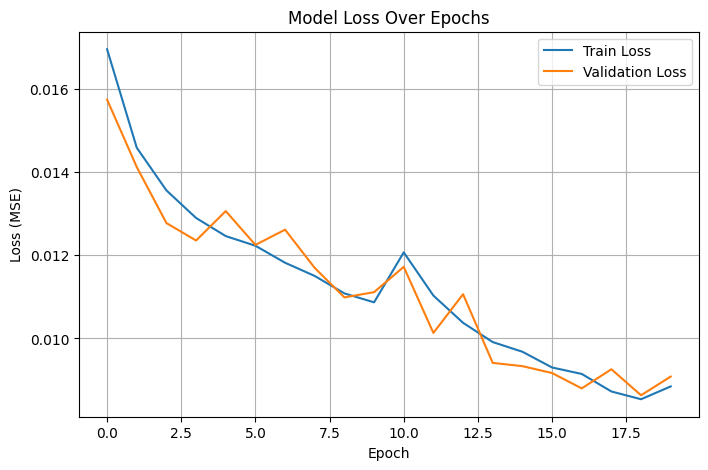

In [ ]:
# Plot the model loss during training
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

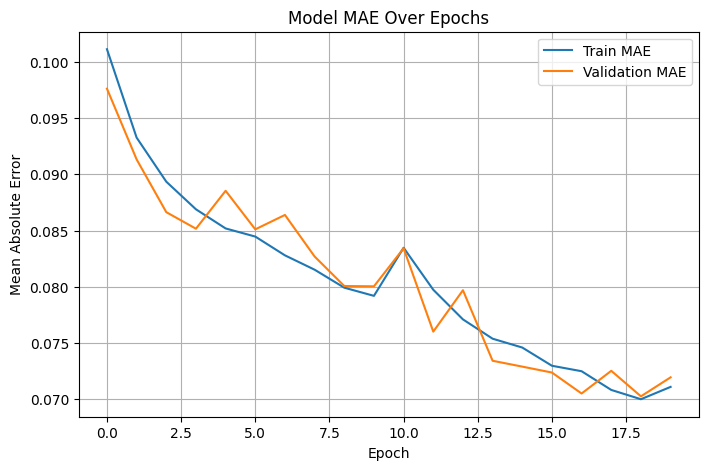

In [ ]:
# Plot the Mean Absolute Error during training
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Save training history to CSV
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'history_crop_yield_BLSTM_20.csv'
hist_df.to_csv(hist_csv_file, index=False)

In [ ]:
# Testing the trained model

# Concatenate x_test and y_test to preprocess test set
x_test_reshape = np.reshape(x_test, (x_test.shape[0] * x_test.shape[1], x_test.shape[2]))
y_test_reshape = np.concatenate((y_test.reshape(-1, 1), np.zeros((x_test.shape[0] * x_test.shape[1] - len(y_test), 1))), axis=0)
data_test = np.concatenate((x_test_reshape, y_test_reshape), axis=1)

# Normalize the test set using the training MinMaxScaler
data_test_scaled = scaler.transform(data_test)
x_test_scaled = data_test_scaled[:, :-1]
x_test_scaled = np.reshape(x_test_scaled, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# Predict on the test set
yhat = model.predict(x_test_scaled)

# Denormalize the predictions and actual values
# Append predictions to test input for inverse transformation
yhat_reshape = np.concatenate((yhat, np.zeros((x_test.shape[0]*x_test.shape[1] - len(yhat), yhat.shape[1]))), axis=0)
data_pred = np.concatenate((x_test_reshape, yhat_reshape), axis=1)

# Inverse transform both true and predicted data
data_actual = scaler.inverse_transform(data_test_scaled)
data_pred = scaler.inverse_transform(data_pred)

inv_y = data_actual[:len(y_test), -1]
inv_yhat = data_pred[:len(y_test), -1]

258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step


In [ ]:
yhat

array([[0.40034112],
       [0.47576907],
       [0.4371021 ],
       ...,
       [0.35333523],
       [0.5738559 ],
       [0.42813522]], dtype=float32)

In [ ]:
def r_square(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2.numpy()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Calculate R², MSE, MAE, RMSE
r2 = r2_score(inv_y, inv_yhat)
mse = mean_squared_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mse)

# Print results
print(f'R² Score       = {r2:.4f}')
print(f'Mean Squared Error (MSE) = {mse:.4f}')
print(f'Mean Absolute Error (MAE) = {mae:.4f}')
print(f'Root Mean Squared Error (RMSE) = {rmse:.4f}')

R² Score       = 0.5034
Mean Squared Error (MSE) = 4.0281
Mean Absolute Error (MAE) = 1.5129
Root Mean Squared Error (RMSE) = 2.0070


In [ ]:
inv_y

array([ 8.37300014, 13.48200035, 11.54300022, ...,  9.56999969,
       12.57299995,  8.58199978])

In [ ]:
inv_yhat

array([ 8.54728314, 10.15766989,  9.3321302 , ...,  7.54370733,
       12.25182319,  9.14068703])

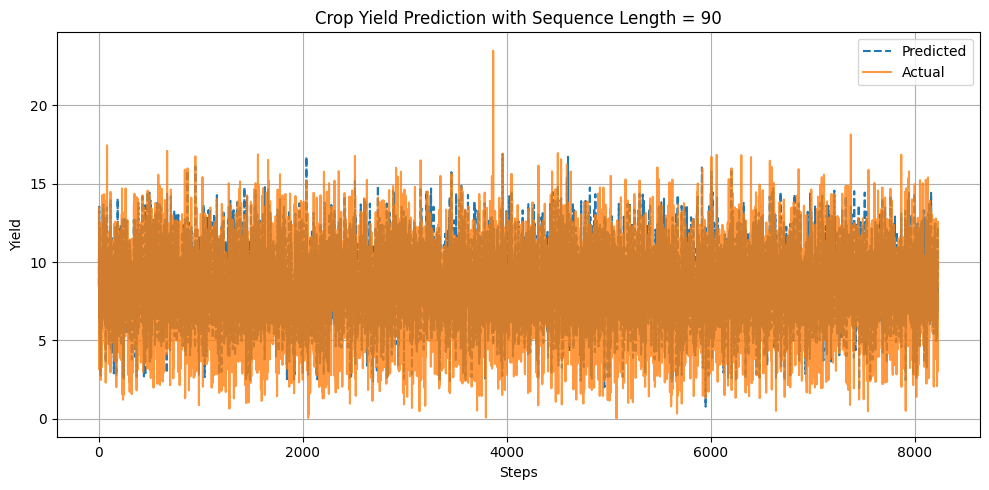

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(inv_yhat, label='Predicted', linestyle='--')
plt.plot(inv_y, label='Actual', alpha=0.8)
plt.title('Crop Yield Prediction with Sequence Length = 90')
plt.ylabel('Yield')
plt.xlabel('Steps')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Create a DataFrame for actual vs predicted values
datapredicted = pd.DataFrame({
    'Actual': inv_y,
    'Predicted': inv_yhat
})

# Print and save to CSV
print(datapredicted.head())  # Show only top few rows for a cleaner output
datapredicted.to_csv("yieldBLSTM_20.csv", index=False)


   Actual  Predicted
0   8.373   8.547283
1  13.482  10.157670
2  11.543   9.332130
3   9.375   7.343466
4  12.226  13.537485


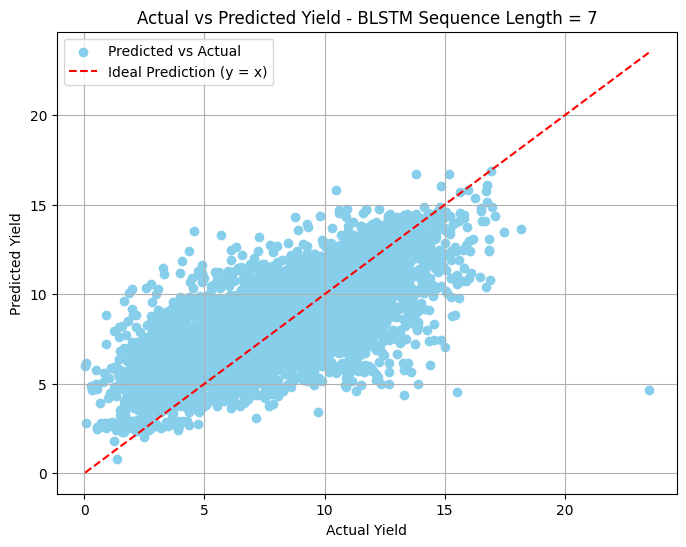

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(inv_y, inv_yhat, color='skyblue', label='Predicted vs Actual')
plt.plot([min(inv_y), max(inv_y)], [min(inv_y), max(inv_y)], color='red', linestyle='--', label='Ideal Prediction (y = x)')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield - BLSTM Sequence Length = 7')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
file2 = '/content/drive/MyDrive/Country Data/maize_India (1).csv'


df2 = pd.read_csv(file2)



# Check for duplicates and remove them if needed
df2 = df2.drop_duplicates()

In [ ]:


df2.drop(['crop', 'State', 'Country'], axis=1, inplace=True)
#remove the columns with missing data
df2.dropna(inplace=True)
#remove the variable with VIF greater than a threshold from the data set
#df.drop(['Tmin','Tmax', 'Humidity_min',  'Humidity_max','Solar R_Avg'],axis=1 ,inplace=True)

In [ ]:
# First split the data for supervised learning using the data_split function
X, Y = data_split(df2)
indices = np.arange(len(X))

In [ ]:
# Testing the trained model

# Concatenate X and Y to preprocess test set
X_reshape = np.reshape(X, (X.shape[0] * X.shape[1], X.shape[2]))
Y_reshape = np.concatenate((Y.reshape(-1, 1), np.zeros((X.shape[0] * X.shape[1] - len(Y), 1))), axis=0)
data_test = np.concatenate((X_reshape, Y_reshape), axis=1)

# Normalize the test set using the training MinMaxScaler
data_test_scaled = scaler.transform(data_test)
X_scaled = data_test_scaled[:, :-1]
X_scaled = np.reshape(X_scaled, (X.shape[0], X.shape[1], X.shape[2]))

# Predict on the test set
yhat = model.predict(X_scaled)

# Denormalize the predictions and actual values
# Append predictions to test input for inverse transformation
yhat_reshape = np.concatenate((yhat, np.zeros((X.shape[0]*X.shape[1] - len(yhat), yhat.shape[1]))), axis=0)
data_pred = np.concatenate((X_reshape, yhat_reshape), axis=1)

# Inverse transform both true and predicted data
data_actual = scaler.inverse_transform(data_test_scaled)
data_pred = scaler.inverse_transform(data_pred)

inv_y = data_actual[:len(Y), -1]
inv_yhat = data_pred[:len(Y), -1]

349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [ ]:
yhat

array([[0.22444208],
       [0.22801507],
       [0.22245418],
       ...,
       [0.21783799],
       [0.22472212],
       [0.22930847]], dtype=float32)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Calculate R², MSE, MAE, RMSE
r2 = r2_score(inv_y, inv_yhat)
mse = mean_squared_error(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = sqrt(mse)

# Print results
print(f'R² Score       = {r2:.4f}')
print(f'Mean Squared Error (MSE) = {mse:.4f}')
print(f'Mean Absolute Error (MAE) = {mae:.4f}')
print(f'Root Mean Squared Error (RMSE) = {rmse:.4f}')

R² Score       = -0.9026
Mean Squared Error (MSE) = 67.2028
Mean Absolute Error (MAE) = 6.6839
Root Mean Squared Error (RMSE) = 8.1977


In [ ]:
inv_y

array([10.8932  , 10.11888 , 17.68923 , ...,  9.93096 , 15.58325 ,
        6.019851])

In [ ]:
inv_yhat

array([4.79183849, 4.86812173, 4.74939673, ..., 4.65084116, 4.79781729,
       4.89573595])

In [ ]:
# Create a DataFrame for actual vs predicted values
datapredicted = pd.DataFrame({
    'Actual': inv_y,
    'Predicted': inv_yhat
})

# Print and save to CSV
print(datapredicted.head())  # Show only top few rows for a cleaner output
datapredicted.to_csv("predicted_2020.csv", index=False)


      Actual  Predicted
0  10.893200   4.791838
1  10.118880   4.868122
2  17.689230   4.749397
3   8.804638   4.250409
4   7.367785   4.849757


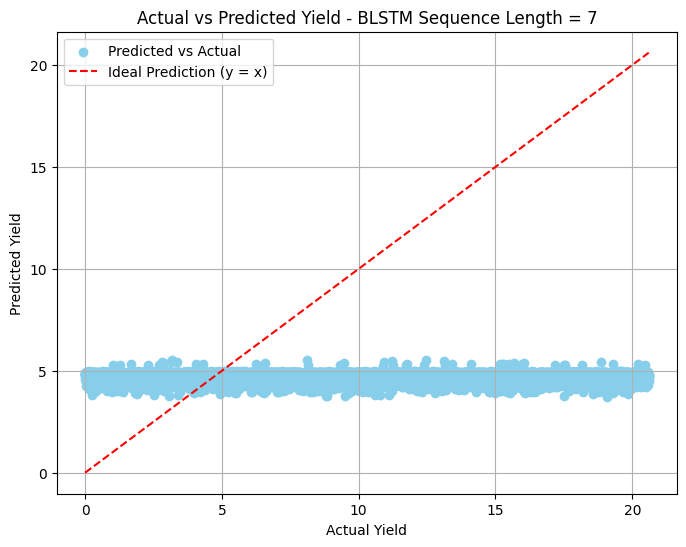

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(inv_y, inv_yhat, color='skyblue', label='Predicted vs Actual')
plt.plot([min(inv_y), max(inv_y)], [min(inv_y), max(inv_y)], color='red', linestyle='--', label='Ideal Prediction (y = x)')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield - BLSTM Sequence Length = 7')
plt.legend()
plt.grid(True)
plt.show()
